# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob as glob
from pathlib import Path

from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, classification_report

# Loading Images

In [2]:
processed_crackdir = Path("../data/external/Crack")
processed_noncrackdir = Path("../data/external/Non-crack")

def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [3]:
crack_df = generate_df(processed_crackdir, label="CRACK_IMAGE")
noncrack_df = generate_df(processed_noncrackdir,label="NONCRACK_IMAGE")

crack_sample = crack_df.sample(n=10000, random_state=42)
noncrack_sample = noncrack_df.sample(n=10000, random_state=42)

total_df = pd.concat([crack_sample, noncrack_sample], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

print(total_df.shape)

(20000, 2)


# Image Feature Extraction

In [4]:
import cv2

def extract_features(df, img_size=(120, 120)):
    features, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row['Filepath'], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        
        hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        
        features.append(hog_features)
        labels.append(1 if row['Label'] == 'CRACK_IMAGE' else 0)
        
    return np.array(features), np.array(labels)


In [5]:
X, y = extract_features(total_df)

In [6]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


# Evaluate SVM


In [7]:
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
y_scores = svm_model.decision_function(X_test)

# Evaluate RandomForest

In [8]:
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Model Performance Visualization SVM & RF

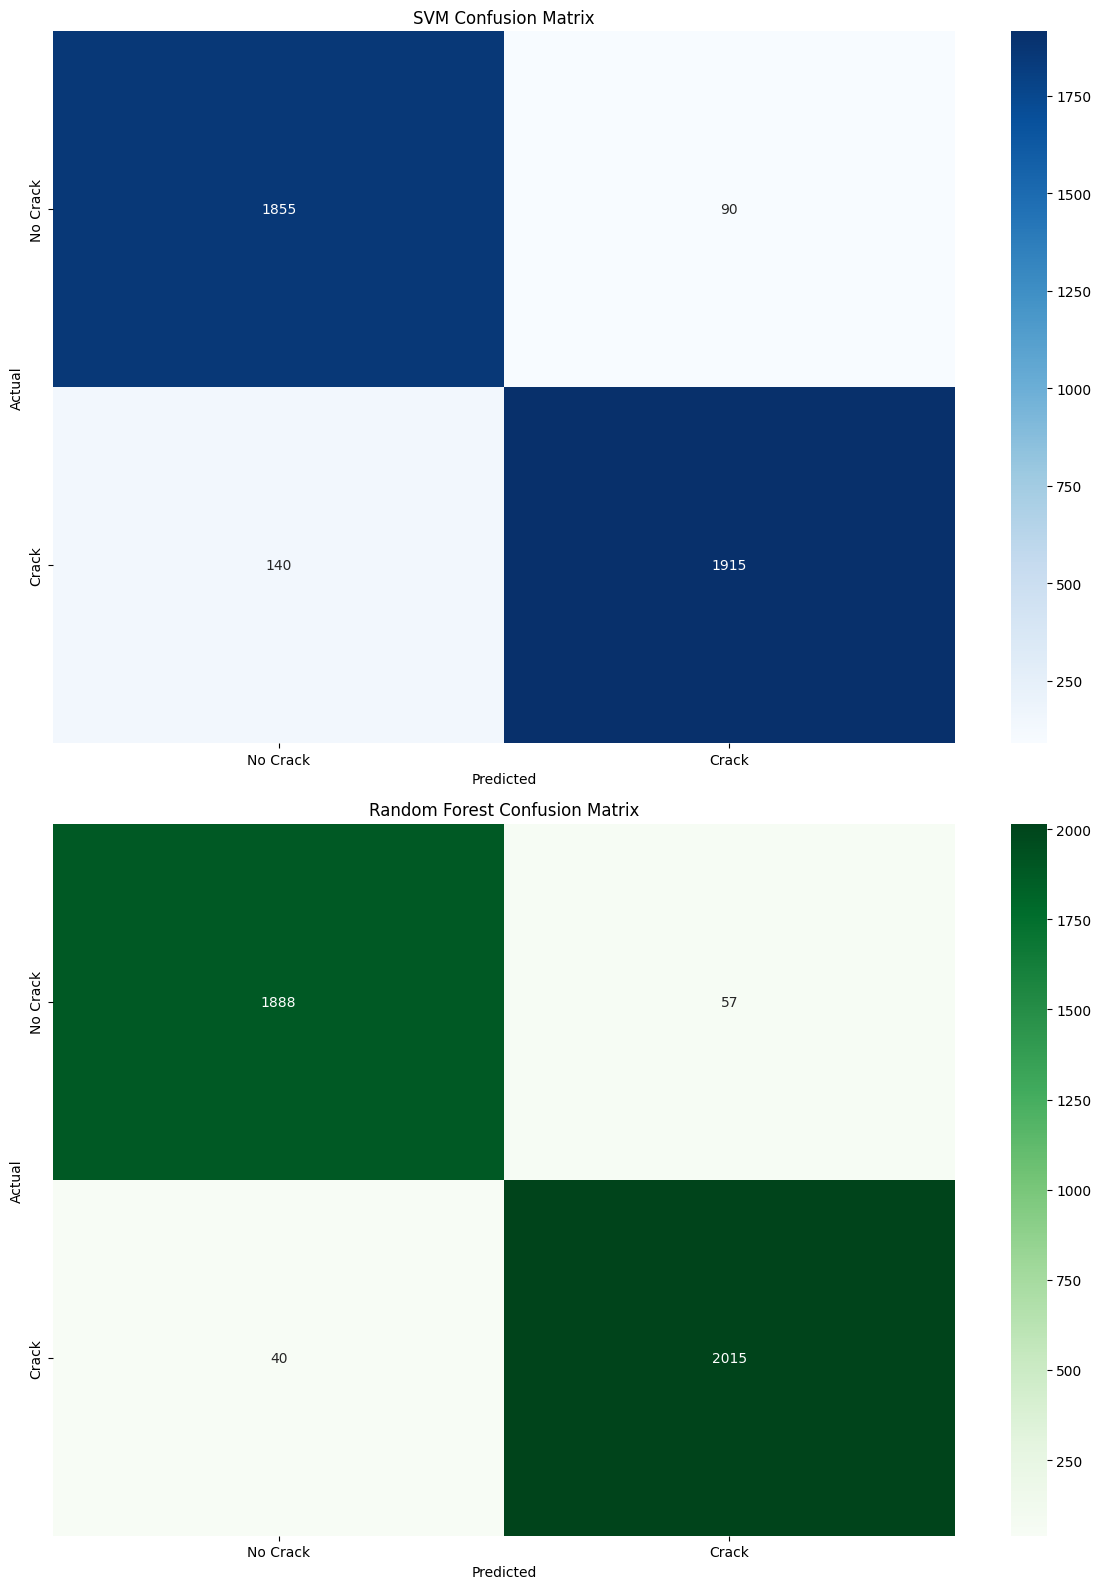

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1945
           1       0.96      0.93      0.94      2055

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1945
           1       0.97      0.98      0.98      2055

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



In [11]:
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8*2))

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm,annot=True, fmt='d', cmap='Blues', xticklabels=["No Crack", "Crack"], yticklabels=["No Crack", "Crack"], ax=axes[0])
axes[0].set_title("SVM Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=["No Crack", "Crack"], yticklabels=["No Crack", "Crack"],ax=axes[1])
axes[1].set_title("Random Forest Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# Adjust layout and show
plt.tight_layout()
plt.show()

# Print Classification Reports
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
svm_report = classification_report(y_test, y_pred_svm, output_dict=True)

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)


# Logging model into MLflow

In [12]:
import dagshub

dagshub.init(repo_owner='Saipr14', repo_name='ML-Surface-Crack-Detection', mlflow=True)

Initialized MLflow to track repo "Saipr14/ML-Surface-Crack-Detection"

Repository Saipr14/ML-Surface-Crack-Detection initialized!

In [14]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

mlflow.set_experiment("SCD Experiments-NoPreprocess")

X_sample = X_test[:5] 
y_sample = rf_model.predict(X_sample)

with mlflow.start_run(run_name="SVM Model"):
    mlflow.log_params({
        "Model_name":"Non-pre SVM Model",
        "n_estimators":100,
        "random_state":42})
    mlflow.log_metrics(
        {
        "accuracy": svm_report["accuracy"],
        "precision": svm_report["weighted avg"]["precision"],
        "recall": svm_report["weighted avg"]["recall"],
        "f1-score": svm_report["weighted avg"]["f1-score"]
        })

    mlflow.sklearn.log_model(
         rf_model, 
        "rf_model",
        signature=infer_signature(X_sample, y_sample),
        input_example=X_sample
    )


🏃 View run SVM Model at: https://dagshub.com/Saipr14/ML-Surface-Crack-Detection.mlflow/#/experiments/2/runs/54862d33674849058afafc5a21e382b7
🧪 View experiment at: https://dagshub.com/Saipr14/ML-Surface-Crack-Detection.mlflow/#/experiments/2


# SVM Model Trained and Logged